In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set visualization style
sns.set(style="whitegrid")


In [5]:
!pip install openpyxl



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
%pip install openpyxl


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd

# Read Excel file after installing openpyxl
df = pd.read_excel(r"D:\Backup\Downloads\archive (6)\online_retail_II.xlsx")

df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [11]:
# See raw column names
print(df.columns.tolist())

# Clean and standardize them
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Print again to confirm changes
print(df.columns.tolist())


['invoice', 'stockcode', 'description', 'quantity', 'invoicedate', 'price', 'customer_id', 'country']
['invoice', 'stockcode', 'description', 'quantity', 'invoicedate', 'price', 'customer_id', 'country']


In [12]:
df.dropna(subset=['customer_id'], inplace=True)


In [14]:
# Step 1: Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Step 2: Drop rows with missing customer_id
df.dropna(subset=['customer_id'], inplace=True)

# Step 3: Remove rows with zero or negative quantity
df = df[df['quantity'] > 0]

# Step 4: Create TotalPrice column
df['total_price'] = df['quantity'] * df['price']

# Step 5: Check the cleaned data
df.head()


,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country,total_price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [17]:
# Use one day after the latest invoice as reference
NOW = df['invoicedate'].max() + pd.Timedelta(days=1)


In [18]:
# Group by customer_id to calculate Recency, Frequency, Monetary
rfm = df.groupby('customer_id').agg({
    'invoicedate': lambda x: (NOW - x.max()).days,  # Recency
    'invoice': 'nunique',                          # Frequency
    'total_price': 'sum'                           # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
rfm.head()


,customer_id,recency,frequency,monetary
0,12346.0,165,11,372.86
1,12347.0,3,2,1323.32
2,12348.0,74,1,222.16
3,12349.0,43,3,2671.14
4,12351.0,11,1,300.93


In [19]:
# Score from 1 (low) to 4 (high)
rfm['R'] = pd.qcut(rfm['recency'], 4, labels=[4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M'] = pd.qcut(rfm['monetary'], 4, labels=[1, 2, 3, 4])

# Combine scores into one string
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm.head()


,customer_id,recency,frequency,monetary,R,F,M,RFM_Score
0,12346.0,165,11,372.86,1,4,2,142
1,12347.0,3,2,1323.32,4,2,3,423
2,12348.0,74,1,222.16,2,1,1,211
3,12349.0,43,3,2671.14,3,3,4,334
4,12351.0,11,1,300.93,4,1,1,411


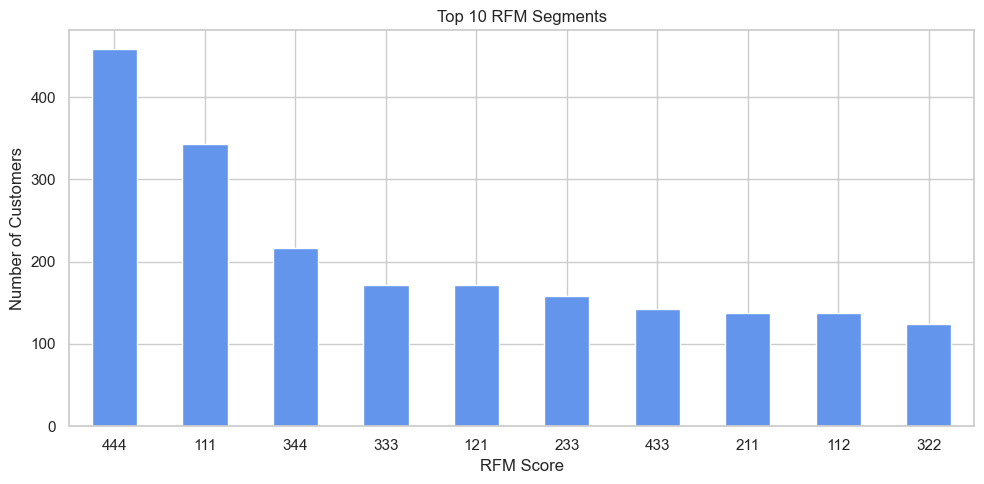

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
rfm['RFM_Score'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar', color='cornflowerblue')
plt.title('Top 10 RFM Segments')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [21]:
rfm.to_csv("rfm_customer_segments.csv", index=False)
